# ML Signal Generator - Training Pipeline

This notebook demonstrates the complete pipeline for:
1. Downloading market data
2. Engineering features
3. Training ML models
4. Generating trading signals
5. Backtesting performance

In [2]:
import sys
import os
from pathlib import Path
from dotenv import load_dotenv

# Get the project root directory (parent of notebooks directory)
current_dir = Path(os.getcwd())
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    # If running from project root, notebooks should be in notebooks/ subdirectory
    project_root = current_dir

# Load environment variables from .env file
env_path = project_root / '.env'
if env_path.exists():
    load_dotenv(env_path)
    print(f"✓ Loaded environment variables from .env")
else:
    print(f"⚠️  No .env file found. Using defaults. Create .env from .env.example if needed.")

# Add project root to path so "import src" works
sys.path.insert(0, str(project_root))

# Set output directory
output_dir = project_root / 'outputs'
output_dir.mkdir(exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display  # For better DataFrame display in Jupyter

from src.features import download_data, engineer_features, prepare_features_for_training
from src.model import time_series_split, train_random_forest, train_xgboost, get_feature_importance, evaluate_model
from src.backtest import generate_signals, backtest_strategy, plot_equity_curve, plot_feature_importance

print(f"Project root: {project_root}")
print(f"Output directory: {output_dir}")

✓ Loaded environment variables from .env
Project root: c:\Users\Gaspar\Documents\ML-Signal-Generator
Output directory: c:\Users\Gaspar\Documents\ML-Signal-Generator\outputs


## 1. Download Data

In [3]:
# Configuration
TICKER = 'SPY'  # S&P 500 ETF
START_DATE = '2020-01-01'
END_DATE = '2024-01-01'

# API Configuration (loads from .env file, with fallback to defaults)
# Options: 'yfinance' (default, free but rate limited), 'alpha_vantage' (free with API key)
# NOTE: If Alpha Vantage gives errors, you can override here: API_SOURCE = 'yfinance'
API_SOURCE = os.getenv('API_SOURCE', 'yfinance')  # Load from .env or use default

# Get API key from .env based on source
if API_SOURCE == 'alpha_vantage':
    API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')
else:
    API_KEY = None  # yfinance doesn't need an API key

# Display API configuration
print(f"API Source: {API_SOURCE}")
if API_KEY:
    print(f"API Key: {'*' * (len(API_KEY) - 4) + API_KEY[-4:]}")  # Show only last 4 chars
else:
    print("API Key: Not set (using yfinance or not required)")
    if API_SOURCE == 'alpha_vantage':
        print(f"⚠️  WARNING: {API_SOURCE} requires an API key but none was found!")
        print("   Either add API key to .env or set API_SOURCE='yfinance'")

# Quick fix: If Alpha Vantage fails, uncomment the line below to force yfinance:
# API_SOURCE = 'yfinance'

# Instructions for setting up .env:
# 1. Copy .env.example to .env: cp .env.example .env
# 2. Edit .env and add your API keys
# 3. Get free API keys:
#    - Alpha Vantage: https://www.alphavantage.co/support/#api-key

# OPTION: Set to True to skip download and use sample data (for testing when rate limited)
USE_SAMPLE_DATA = False  # Set to True if you're rate limited and want to continue

# Try to load from saved file first (checks both CSV and Excel)
data_file_csv = project_root / 'data' / f'{TICKER}_{START_DATE}_{END_DATE}.csv'
data_file_xlsx = project_root / 'data' / f'{TICKER}_{START_DATE}_{END_DATE}.xlsx'
data = None

# Check for CSV first, then Excel
if data_file_csv.exists():
    print(f"Loading saved data from {data_file_csv.name}...")
    try:
        data = pd.read_csv(data_file_csv, index_col=0, parse_dates=True)
        print(f"✓ Loaded {len(data)} days of saved data from CSV")
    except Exception as e:
        print(f"⚠️  Error loading CSV: {e}")
        data = None
elif data_file_xlsx.exists():
    print(f"Loading saved data from {data_file_xlsx.name}...")
    try:
        data = pd.read_excel(data_file_xlsx, index_col=0, parse_dates=True)
        print(f"✓ Loaded {len(data)} days of saved data from Excel")
    except Exception as e:
        print(f"⚠️  Error loading Excel: {e}")
        data = None

# If no saved data, try to download
if data is None or data.empty:
    print(f"\nDownloading data for {TICKER}...")
    import time
    
    max_retries = 3
    retry_delay = 30  # seconds - increased to 30 seconds between retries
    initial_wait = 60  # Wait 60 seconds before first attempt if recently rate limited
    
    for attempt in range(max_retries):
        # Wait before first attempt if this is a retry (not the first attempt)
        if attempt > 0:
            wait_time = retry_delay * attempt
            print(f"Waiting {wait_time} seconds before retry attempt {attempt + 1}/{max_retries}...")
            time.sleep(wait_time)
        
        try:
            data = download_data(TICKER, START_DATE, END_DATE, api_source=API_SOURCE, api_key=API_KEY)
            
            # Check if download was successful
            if data.empty or len(data) == 0:
                if attempt < max_retries - 1:
                    # Will wait at start of next loop iteration
                    print(f"Download returned empty data. Will retry... (Attempt {attempt + 1}/{max_retries})")
                    continue
                else:
                    raise ValueError(f"Failed to download data for {TICKER} after {max_retries} attempts.")
            
            # Save data for future use
            data_dir = project_root / 'data'
            data_dir.mkdir(exist_ok=True)
            data.to_csv(data_file_csv)
            print(f"✓ Data saved to {data_file_csv.name} for future use")
            break
            
        except Exception as e:
            error_msg = str(e).lower()
            error_type = type(e).__name__
            
            # Check for rate limit errors (both in message and exception type)
            is_rate_limit = (
                'rate limit' in error_msg or 
                'too many requests' in error_msg or
                'YFRateLimitError' in error_type or
                'ratelimit' in error_msg
            )
            
            if is_rate_limit:
                if attempt < max_retries - 1:
                    # Will wait at start of next loop iteration
                    print(f"Rate limit hit. Will retry with longer wait... (Attempt {attempt + 1}/{max_retries})")
                    continue
                else:
                    print(f"\n❌ Rate limited after {max_retries} attempts.")
                    print("\n" + "="*60)
                    print("YAHOO FINANCE RATE LIMIT - SOLUTIONS:")
                    print("="*60)
                    print("1. Wait 15-20 minutes, then run this cell again")
                    print("2. Try again later today (rate limits reset over time)")
                    print("3. Once data downloads successfully, it will be saved")
                    print("   and you won't need to download again")
                    print("="*60)
                    raise ValueError(f"Rate limited by Yahoo Finance. Please wait 15-20 minutes and try again.")
            else:
                # For other errors, raise immediately
                print(f"Error: {e}")
                raise

# If still no data and USE_SAMPLE_DATA is True, generate sample data
if (data is None or data.empty) and USE_SAMPLE_DATA:
    print("\n⚠️  Using sample data (USE_SAMPLE_DATA=True)")
    print("This is synthetic data for testing purposes only!")
    
    # Generate sample OHLC data
    dates = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
    dates = dates[dates.weekday < 5]  # Only weekdays
    
    np.random.seed(42)
    n_days = len(dates)
    base_price = 400.0
    
    # Generate realistic price movements
    returns = np.random.normal(0.0005, 0.015, n_days)  # Daily returns
    prices = base_price * np.exp(np.cumsum(returns))
    
    # Generate OHLC from close prices
    data = pd.DataFrame({
        'Open': prices * (1 + np.random.normal(0, 0.002, n_days)),
        'High': prices * (1 + np.abs(np.random.normal(0, 0.005, n_days))),
        'Low': prices * (1 - np.abs(np.random.normal(0, 0.005, n_days))),
        'Close': prices,
        'Volume': np.random.randint(50000000, 200000000, n_days)
    }, index=dates)
    
    # Ensure High >= Close >= Low and High >= Open >= Low
    data['High'] = data[['Open', 'High', 'Close']].max(axis=1) * 1.001
    data['Low'] = data[['Open', 'Low', 'Close']].min(axis=1) * 0.999
    
    print(f"✓ Generated {len(data)} days of sample data")
    print(f"Date range: {data.index[0]} to {data.index[-1]}")
    print(f"\n⚠️  WARNING: This is synthetic data, not real market data!")
    print(f"   Set USE_SAMPLE_DATA=False and wait 15-20 minutes to download real data.")

# Display data info
if data is not None and not data.empty:
    print(f"\n✓ Successfully loaded {len(data)} days of data")
    print(f"Date range: {data.index[0]} to {data.index[-1]}")
    print(f"\nData preview:")
    display(data.head())  # Use display() to ensure it shows in Jupyter
else:
    print("\n" + "="*70)
    print("NO DATA AVAILABLE - OPTIONS:")
    print("="*70)
    print("1. Wait 15-20 minutes, then run this cell again")
    print("2. Set USE_SAMPLE_DATA = True at the top of this cell to use sample data")
    print("   (for testing purposes only - not real market data)")
    print("3. Try again later today (rate limits reset over time)")
    print("="*70)
    raise ValueError("No data available. Set USE_SAMPLE_DATA=True to continue with sample data, or wait and try downloading again.")

API Source: yfinance
API Key: Not set (using yfinance or not required)

✓ Data saved to SPY_2020-01-01_2024-01-01.csv for future use

✓ Successfully loaded 1006 days of data
Date range: 2020-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00

Data preview:


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2020-01-02 00:00:00-05:00,296.480224,297.717320,295.554688,297.698975,59151200,0.0,0.0,0.0
2020-01-03 00:00:00-05:00,294.299370,296.571962,294.244390,295.444824,77709700,0.0,0.0,0.0
2020-01-06 00:00:00-05:00,293.685241,296.654277,293.566110,296.571808,55653900,0.0,0.0,0.0
2020-01-07 00:00:00-05:00,296.003640,296.480167,295.288878,295.737915,40496400,0.0,0.0,0.0
2020-01-08 00:00:00-05:00,295.930339,298.532807,295.682931,297.314056,68296000,0.0,0.0,0.0


## 2. Feature Engineering

In [4]:
# Engineer features
print("Engineering features...")
data_features = engineer_features(
    data,
    return_periods=[1, 5],
    volatility_window=20,
    ma_windows=[5, 20]
)

# Prepare features for training
X, y = prepare_features_for_training(data_features)
print(f"\nFeatures shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"\nFeature columns: {list(X.columns)}")

Engineering features...

Features shape: (986, 6)
Target distribution:
target
1    529
0    457
Name: count, dtype: int64

Feature columns: ['return_1d', 'return_5d', 'volatility_20d', 'ma_5d', 'ma_20d', 'ma_gap']


## 3. Train-Test Split (Time Series Aware)

In [5]:
# Combine X and y for time series split
data_combined = pd.concat([X, y], axis=1)

# Split data
train, val, test = time_series_split(data_combined, train_size=0.7, val_size=0.15)

X_train = train[X.columns]
y_train = train['target']
X_val = val[X.columns]
y_val = val['target']
X_test = test[X.columns]
y_test = test['target']

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 690 samples
Validation set: 148 samples
Test set: 148 samples


## 4. Train Model

In [6]:
# Train both models for comparison
print("="*70)
print("TRAINING BOTH MODELS")
print("="*70)

# Train Random Forest
print("\n1. Training Random Forest...")
model_rf, metrics_rf = train_random_forest(
    X_train, y_train,
    X_val, y_val,
    n_estimators=100,
    max_depth=10,
    random_state=42
)

print(f"\nRandom Forest Validation Metrics:")
print(f"  AUC: {metrics_rf['auc']:.4f}")
print(f"  Train Accuracy: {metrics_rf['train_accuracy']:.4f}")
print(f"  Validation Accuracy: {metrics_rf['val_accuracy']:.4f}")

# Train XGBoost
print("\n2. Training XGBoost...")
model_xgb, metrics_xgb = train_xgboost(
    X_train, y_train,
    X_val, y_val,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

print(f"\nXGBoost Validation Metrics:")
print(f"  AUC: {metrics_xgb['auc']:.4f}")
print(f"  Train Accuracy: {metrics_xgb['train_accuracy']:.4f}")
print(f"  Validation Accuracy: {metrics_xgb['val_accuracy']:.4f}")

# Model Comparison
print("\n" + "="*70)
print("MODEL COMPARISON (Validation Set)")
print("="*70)
print(f"{'Metric':<25} {'Random Forest':<20} {'XGBoost':<20}")
print("-"*70)
print(f"{'AUC':<25} {metrics_rf['auc']:<20.4f} {metrics_xgb['auc']:<20.4f}")
print(f"{'Train Accuracy':<25} {metrics_rf['train_accuracy']:<20.4f} {metrics_xgb['train_accuracy']:<20.4f}")
print(f"{'Validation Accuracy':<25} {metrics_rf['val_accuracy']:<20.4f} {metrics_xgb['val_accuracy']:<20.4f}")

# Determine which model performs better on validation
if metrics_rf['auc'] > metrics_xgb['auc']:
    print(f"\n✓ Random Forest has better AUC on validation set")
    best_model_name = 'Random Forest'
    best_model = model_rf
    best_metrics = metrics_rf
    print(f"\nUsing {best_model_name} for further analysis...")
elif metrics_xgb['auc'] > metrics_rf['auc']:
    print(f"\n✓ XGBoost has better AUC on validation set")
    best_model_name = 'XGBoost'
    best_model = model_xgb
    best_metrics = metrics_xgb
    print(f"\nUsing {best_model_name} for further analysis...")
else:
    print(f"\n✓ Both models have similar AUC on validation set (no clear winner)")
    best_model_name = None
    best_model = None
    best_metrics = None

TRAINING BOTH MODELS

1. Training Random Forest...

Random Forest Validation Metrics:
  AUC: 0.5401
  Train Accuracy: 0.9739
  Validation Accuracy: 0.5270

2. Training XGBoost...

XGBoost Validation Metrics:
  AUC: 0.4782
  Train Accuracy: 0.9855
  Validation Accuracy: 0.4797

MODEL COMPARISON (Validation Set)
Metric                    Random Forest        XGBoost             
----------------------------------------------------------------------
AUC                       0.5401               0.4782              
Train Accuracy            0.9739               0.9855              
Validation Accuracy       0.5270               0.4797              

✓ Random Forest has better AUC on validation set

Using Random Forest for further analysis...


## 5. Feature Importance

In [7]:
# Get feature importance for both models
print("="*70)
print("FEATURE IMPORTANCE COMPARISON")
print("="*70)

importance_df_rf = get_feature_importance(model_rf, list(X.columns))
importance_df_xgb = get_feature_importance(model_xgb, list(X.columns))

print("\nRandom Forest Feature Importance:")
print(importance_df_rf)

print("\nXGBoost Feature Importance:")
print(importance_df_xgb)

# Plot feature importance for both models
# Ensure output_dir is defined (from Cell 1)
if 'output_dir' not in globals():
    from pathlib import Path
    output_dir = Path('outputs')
    output_dir.mkdir(exist_ok=True)

feature_importance_path_rf = str(output_dir / 'feature_importance_rf.png')
feature_importance_path_xgb = str(output_dir / 'feature_importance_xgb.png')

plot_feature_importance(importance_df_rf, feature_importance_path_rf)
plot_feature_importance(importance_df_xgb, feature_importance_path_xgb)

print(f"\n✓ Feature importance plots saved:")
print(f"  - Random Forest: {feature_importance_path_rf}")
print(f"  - XGBoost: {feature_importance_path_xgb}")

FEATURE IMPORTANCE COMPARISON

Random Forest Feature Importance:
          feature  importance
0       return_1d    0.185377
2  volatility_20d    0.170389
1       return_5d    0.168369
4          ma_20d    0.160628
3           ma_5d    0.157910
5          ma_gap    0.157327

XGBoost Feature Importance:
          feature  importance
1       return_5d    0.187457
2  volatility_20d    0.171691
4          ma_20d    0.165817
0       return_1d    0.162213
3           ma_5d    0.158162
5          ma_gap    0.154660
Feature importance plot saved to c:\Users\Gaspar\Documents\ML-Signal-Generator\outputs\feature_importance_rf.png
Feature importance plot saved to c:\Users\Gaspar\Documents\ML-Signal-Generator\outputs\feature_importance_xgb.png

✓ Feature importance plots saved:
  - Random Forest: c:\Users\Gaspar\Documents\ML-Signal-Generator\outputs\feature_importance_rf.png
  - XGBoost: c:\Users\Gaspar\Documents\ML-Signal-Generator\outputs\feature_importance_xgb.png


## 6. Evaluate on Test Set

In [8]:
# Evaluate both models on test set
from sklearn.metrics import classification_report

print("="*70)
print("TEST SET EVALUATION - BOTH MODELS")
print("="*70)

# Evaluate Random Forest
print("\n1. Random Forest Test Set Metrics:")
test_results_rf = evaluate_model(model_rf, X_test, y_test)
print(f"  AUC: {test_results_rf['auc']:.4f}")
print(f"  Accuracy: {test_results_rf['accuracy']:.4f}")
print(f"\n  Classification Report:")
print(classification_report(y_test, test_results_rf['y_pred']))

# Evaluate XGBoost
print("\n2. XGBoost Test Set Metrics:")
test_results_xgb = evaluate_model(model_xgb, X_test, y_test)
print(f"  AUC: {test_results_xgb['auc']:.4f}")
print(f"  Accuracy: {test_results_xgb['accuracy']:.4f}")
print(f"\n  Classification Report:")
print(classification_report(y_test, test_results_xgb['y_pred']))

# Comparison
print("\n" + "="*70)
print("TEST SET COMPARISON")
print("="*70)
print(f"{'Metric':<25} {'Random Forest':<20} {'XGBoost':<20}")
print("-"*70)
print(f"{'AUC':<25} {test_results_rf['auc']:<20.4f} {test_results_xgb['auc']:<20.4f}")
print(f"{'Accuracy':<25} {test_results_rf['accuracy']:<20.4f} {test_results_xgb['accuracy']:<20.4f}")

TEST SET EVALUATION - BOTH MODELS

1. Random Forest Test Set Metrics:
  AUC: 0.4648
  Accuracy: 0.5203

  Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.13      0.18        63
           1       0.56      0.81      0.66        85

    accuracy                           0.52       148
   macro avg       0.44      0.47      0.42       148
weighted avg       0.46      0.52      0.46       148


2. XGBoost Test Set Metrics:
  AUC: 0.4313
  Accuracy: 0.4662

  Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.24      0.28        63
           1       0.53      0.64      0.58        85

    accuracy                           0.47       148
   macro avg       0.43      0.44      0.43       148
weighted avg       0.44      0.47      0.45       148


TEST SET COMPARISON
Metric                    Random Forest        XGBoost             
---------------------------------------

## 6.5. ROC Curve Comparison


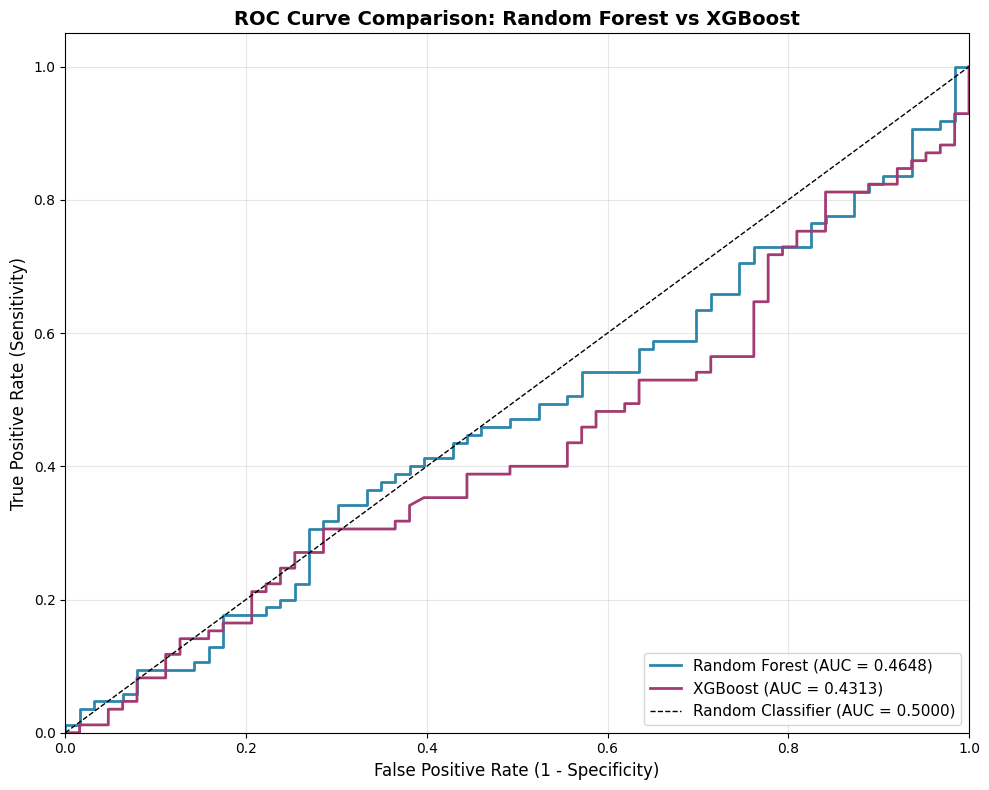

✓ ROC curve saved to: c:\Users\Gaspar\Documents\ML-Signal-Generator\outputs\roc_curve.png

AUC Comparison:
  Random Forest: 0.4648
  XGBoost: 0.4313
  Difference: 0.0335 (RF is better)


In [9]:
# Plot ROC curves for both models
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Ensure output_dir is defined (from Cell 1)
if 'output_dir' not in globals():
    from pathlib import Path
    output_dir = Path('outputs')
    output_dir.mkdir(exist_ok=True)

# Get ROC curves for both models
fpr_rf, tpr_rf, _ = roc_curve(y_test, test_results_rf['y_pred_proba'])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, test_results_xgb['y_pred_proba'])

# Calculate AUC (already computed, but for display)
auc_rf = test_results_rf['auc']
auc_xgb = test_results_xgb['auc']

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', linewidth=2, color='#2E86AB')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})', linewidth=2, color='#A23B72')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.5000)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC Curve Comparison: Random Forest vs XGBoost', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
roc_curve_path = str(output_dir / 'roc_curve.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC curve saved to: {roc_curve_path}")
print(f"\nAUC Comparison:")
print(f"  Random Forest: {auc_rf:.4f}")
print(f"  XGBoost: {auc_xgb:.4f}")
print(f"  Difference: {abs(auc_rf - auc_xgb):.4f} ({'RF' if auc_rf > auc_xgb else 'XGB'} is better)")


## 7. Generate Trading Signals

In [10]:
# Generate signals for both models on test set
SIGNAL_THRESHOLD = 0.55  # Probability threshold for signal generation

# Get actual returns for backtesting
test_returns = data_features.loc[X_test.index, 'next_return'].dropna()

# Generate signals for Random Forest
signals_rf = pd.Series(
    generate_signals(test_results_rf['y_pred_proba'], threshold=SIGNAL_THRESHOLD),
    index=X_test.index
)
signals_rf = signals_rf.loc[test_returns.index]

# Generate signals for XGBoost
signals_xgb = pd.Series(
    generate_signals(test_results_xgb['y_pred_proba'], threshold=SIGNAL_THRESHOLD),
    index=X_test.index
)
signals_xgb = signals_xgb.loc[test_returns.index]

print("="*70)
print("SIGNAL GENERATION - BOTH MODELS")
print("="*70)
print(f"\nRandom Forest Signal Statistics:")
print(f"  Total signals: {signals_rf.sum()} out of {len(signals_rf)} days")
print(f"  Signal rate: {signals_rf.mean()*100:.2f}%")

print(f"\nXGBoost Signal Statistics:")
print(f"  Total signals: {signals_xgb.sum()} out of {len(signals_xgb)} days")
print(f"  Signal rate: {signals_xgb.mean()*100:.2f}%")

print(f"\nTest returns range: {test_returns.index[0]} to {test_returns.index[-1]}")

SIGNAL GENERATION - BOTH MODELS

Random Forest Signal Statistics:
  Total signals: 99 out of 147 days
  Signal rate: 67.35%

XGBoost Signal Statistics:
  Total signals: 93 out of 147 days
  Signal rate: 63.27%

Test returns range: 2023-05-31 00:00:00-04:00 to 2023-12-28 00:00:00-05:00


## 8. Backtest Strategy

In [11]:
# Backtest both models
print("="*70)
print("BACKTEST PERFORMANCE - BOTH MODELS")
print("="*70)

# Backtest Random Forest
print("\n1. Random Forest Backtest:")
aligned_data_rf = pd.DataFrame({
    'signals': signals_rf.values,
    'returns': test_returns.values
}, index=signals_rf.index)

equity_rf, metrics_rf_bt = backtest_strategy(
    aligned_data_rf['signals'].values,
    aligned_data_rf['returns'].values,
    initial_capital=10000.0
)

if isinstance(equity_rf, pd.Series):
    equity_series_rf = equity_rf.reindex(aligned_data_rf.index)
else:
    equity_series_rf = pd.Series(equity_rf, index=aligned_data_rf.index)

print(f"  Total Return: {metrics_rf_bt['total_return_pct']:.2f}%")
print(f"  Annualized Return: {metrics_rf_bt['annualized_return_pct']:.2f}%")
print(f"  Volatility: {metrics_rf_bt['volatility_pct']:.2f}%")
print(f"  Sharpe Ratio: {metrics_rf_bt['sharpe_ratio']:.2f}")
print(f"  Max Drawdown: {metrics_rf_bt['max_drawdown_pct']:.2f}%")
print(f"  Win Rate: {metrics_rf_bt['win_rate_pct']:.2f}%")
print(f"  Total Trades: {metrics_rf_bt['total_trades']}")

# Backtest XGBoost
print("\n2. XGBoost Backtest:")
aligned_data_xgb = pd.DataFrame({
    'signals': signals_xgb.values,
    'returns': test_returns.values
}, index=signals_xgb.index)

equity_xgb, metrics_xgb_bt = backtest_strategy(
    aligned_data_xgb['signals'].values,
    aligned_data_xgb['returns'].values,
    initial_capital=10000.0
)

if isinstance(equity_xgb, pd.Series):
    equity_series_xgb = equity_xgb.reindex(aligned_data_xgb.index)
else:
    equity_series_xgb = pd.Series(equity_xgb, index=aligned_data_xgb.index)

print(f"  Total Return: {metrics_xgb_bt['total_return_pct']:.2f}%")
print(f"  Annualized Return: {metrics_xgb_bt['annualized_return_pct']:.2f}%")
print(f"  Volatility: {metrics_xgb_bt['volatility_pct']:.2f}%")
print(f"  Sharpe Ratio: {metrics_xgb_bt['sharpe_ratio']:.2f}")
print(f"  Max Drawdown: {metrics_xgb_bt['max_drawdown_pct']:.2f}%")
print(f"  Win Rate: {metrics_xgb_bt['win_rate_pct']:.2f}%")
print(f"  Total Trades: {metrics_xgb_bt['total_trades']}")

# Comprehensive Comparison
print("\n" + "="*70)
print("BACKTEST PERFORMANCE COMPARISON")
print("="*70)
print(f"{'Metric':<25} {'Random Forest':<20} {'XGBoost':<20} {'Winner':<15}")
print("-"*80)
print(f"{'Total Return (%)':<25} {metrics_rf_bt['total_return_pct']:<20.2f} {metrics_xgb_bt['total_return_pct']:<20.2f} {('RF' if metrics_rf_bt['total_return_pct'] > metrics_xgb_bt['total_return_pct'] else 'XGB'):<15}")
print(f"{'Annualized Return (%)':<25} {metrics_rf_bt['annualized_return_pct']:<20.2f} {metrics_xgb_bt['annualized_return_pct']:<20.2f} {('RF' if metrics_rf_bt['annualized_return_pct'] > metrics_xgb_bt['annualized_return_pct'] else 'XGB'):<15}")
print(f"{'Sharpe Ratio':<25} {metrics_rf_bt['sharpe_ratio']:<20.2f} {metrics_xgb_bt['sharpe_ratio']:<20.2f} {('RF' if metrics_rf_bt['sharpe_ratio'] > metrics_xgb_bt['sharpe_ratio'] else 'XGB'):<15}")
print(f"{'Max Drawdown (%)':<25} {metrics_rf_bt['max_drawdown_pct']:<20.2f} {metrics_xgb_bt['max_drawdown_pct']:<20.2f} {('RF' if metrics_rf_bt['max_drawdown_pct'] > metrics_xgb_bt['max_drawdown_pct'] else 'XGB'):<15}")
print(f"{'Win Rate (%)':<25} {metrics_rf_bt['win_rate_pct']:<20.2f} {metrics_xgb_bt['win_rate_pct']:<20.2f} {('RF' if metrics_rf_bt['win_rate_pct'] > metrics_xgb_bt['win_rate_pct'] else 'XGB'):<15}")
print(f"{'Total Trades':<25} {metrics_rf_bt['total_trades']:<20} {metrics_xgb_bt['total_trades']:<20} {'-':<15}")

# Determine overall best model based on Sharpe ratio (risk-adjusted return)
if metrics_rf_bt['sharpe_ratio'] > metrics_xgb_bt['sharpe_ratio']:
    best_backtest_model = 'Random Forest'
    best_equity_series = equity_series_rf
    best_metrics_bt = metrics_rf_bt
elif metrics_xgb_bt['sharpe_ratio'] > metrics_rf_bt['sharpe_ratio']:
    best_backtest_model = 'XGBoost'
    best_equity_series = equity_series_xgb
    best_metrics_bt = metrics_xgb_bt
else:
    # If Sharpe is equal, use total return
    if metrics_rf_bt['total_return_pct'] > metrics_xgb_bt['total_return_pct']:
        best_backtest_model = 'Random Forest'
        best_equity_series = equity_series_rf
        best_metrics_bt = metrics_rf_bt
    else:
        best_backtest_model = 'XGBoost'
        best_equity_series = equity_series_xgb
        best_metrics_bt = metrics_xgb_bt

print(f"\n✓ Best model for backtesting (by Sharpe Ratio): {best_backtest_model}")
print(f"  Sharpe Ratio: {best_metrics_bt['sharpe_ratio']:.2f}")
print(f"  Total Return: {best_metrics_bt['total_return_pct']:.2f}%")

BACKTEST PERFORMANCE - BOTH MODELS

1. Random Forest Backtest:
  Total Return: 0.71%
  Annualized Return: 1.22%
  Volatility: 9.83%
  Sharpe Ratio: 0.12
  Max Drawdown: -12.35%
  Win Rate: 46.15%
  Total Trades: 99

2. XGBoost Backtest:
  Total Return: -0.66%
  Annualized Return: -1.13%
  Volatility: 9.71%
  Sharpe Ratio: -0.12
  Max Drawdown: -11.55%
  Win Rate: 42.11%
  Total Trades: 93

BACKTEST PERFORMANCE COMPARISON
Metric                    Random Forest        XGBoost              Winner         
--------------------------------------------------------------------------------
Total Return (%)          0.71                 -0.66                RF             
Annualized Return (%)     1.22                 -1.13                RF             
Sharpe Ratio              0.12                 -0.12                RF             
Max Drawdown (%)          -12.35               -11.55               XGB            
Win Rate (%)              46.15                42.11                RF    

## 9. Plot Results

In [12]:
# Plot equity curves for both models
# Ensure output_dir is defined (from Cell 1)
if 'output_dir' not in globals():
    from pathlib import Path
    output_dir = Path('outputs')
    output_dir.mkdir(exist_ok=True)

# Plot Random Forest equity curve
equity_curve_path_rf = str(output_dir / 'equity_curve_rf.png')
plot_equity_curve(equity_series_rf, equity_curve_path_rf, 'Random Forest Strategy Equity Curve')

# Plot XGBoost equity curve
equity_curve_path_xgb = str(output_dir / 'equity_curve_xgb.png')
plot_equity_curve(equity_series_xgb, equity_curve_path_xgb, 'XGBoost Strategy Equity Curve')

# Plot best model (for compatibility with existing code)
equity_curve_path = str(output_dir / 'equity_curve.png')
plot_equity_curve(best_equity_series, equity_curve_path, f'{best_backtest_model} Strategy Equity Curve (Best)')

print(f"\n✓ Equity curves saved:")
print(f"  - Random Forest: {equity_curve_path_rf}")
print(f"  - XGBoost: {equity_curve_path_xgb}")
print(f"  - Best Model ({best_backtest_model}): {equity_curve_path}")

Equity curve saved to c:\Users\Gaspar\Documents\ML-Signal-Generator\outputs\equity_curve_rf.png
Equity curve saved to c:\Users\Gaspar\Documents\ML-Signal-Generator\outputs\equity_curve_xgb.png
Equity curve saved to c:\Users\Gaspar\Documents\ML-Signal-Generator\outputs\equity_curve.png

✓ Equity curves saved:
  - Random Forest: c:\Users\Gaspar\Documents\ML-Signal-Generator\outputs\equity_curve_rf.png
  - XGBoost: c:\Users\Gaspar\Documents\ML-Signal-Generator\outputs\equity_curve_xgb.png
  - Best Model (Random Forest): c:\Users\Gaspar\Documents\ML-Signal-Generator\outputs\equity_curve.png
